# Prepare data

In [1]:
import torch
import torchvision.datasets as dsets

In [2]:
# Load train set
train = dsets.MNIST('../', train=True, download=True)
X_train = train.data.reshape(-1, 784).float() / 255.0
Y_train = train.targets.long()
num_features = X_train.shape[1]

# Create validation set
ordering = torch.randperm(len(X_train))
X_train = X_train[ordering]
Y_train = Y_train[ordering]
X_train, X_val = X_train[6000:], X_train[:6000]
Y_train, Y_val = Y_train[6000:], Y_train[:6000]

# Load test set
test = dsets.MNIST('../', train=False, download=True)
X_test = test.data.reshape(-1, 784).float() / 255.0
Y_test = test.targets.long()

# Train model with missing data

- Model will accommodate feature removal automatically.

In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from rexplain.torch import MaskLayer2d
from copy import deepcopy

In [4]:
# Prepare device
device = torch.device('cuda')

# Prepare validation data
X_val_missing = X_val.repeat(100, 1)
Y_val_missing = Y_val.repeat(100)

# Random subsets
S_val = torch.ones(X_val_missing.shape)
num_included = np.random.choice(num_features + 1, size=len(S_val))
for i in range(len(S_val)):
    S_val[i, num_included[i]:] = 0
    S_val[i] = S_val[i, torch.randperm(num_features)]

# Create dataset iterator
val_set = TensorDataset(X_val_missing, Y_val_missing, S_val)
val_loader = DataLoader(val_set, batch_size=2056)

def validate(model):
    '''Measure performance on validation set.'''
    with torch.no_grad():
        # Setup
        mean_loss = 0
        N = 0

        # Iterate over validation set
        for x, y, S in val_loader:
            x = x.to(device)
            y = y.to(device)
            S = S.to(device)
            pred = model((x.view(-1, 1, 28, 28),
                          S.view(-1, 1, 28, 28)))
            loss = loss_fn(pred, y)
            N += len(x)
            mean_loss += len(x) * (loss - mean_loss) / N

    return mean_loss

In [5]:
# Set up model
model = nn.Sequential(
    MaskLayer2d(),
    nn.Conv2d(2, 16, 3, 1),
    nn.ELU(inplace=True),
    nn.Conv2d(16, 32, 3, 1),
    nn.ELU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 3, 1),
    nn.ELU(inplace=True),
    nn.Conv2d(64, 128, 3, 1),
    nn.ELU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(start_dim=1),
    nn.Linear(2048, 256),
    nn.ELU(inplace=True),
    nn.Linear(256, 10)).to(device)

# Training parameters
lr = 1e-3
nepochs = 1000
early_stop_epochs = 10

# Loss function
loss_fn = nn.CrossEntropyLoss()
loss_list = []

for mbsize in (128, 512, 2048, 5096, 10192):
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Set up data loaders
    train_set = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_set, batch_size=mbsize,
                              shuffle=True, drop_last=True)

    # For saving best model
    min_epoch = 0
    best_model = deepcopy(model)
    best_epoch_loss = validate(model).item()
    best_epoch = 0

    # Begin training
    for epoch in range(nepochs):
        for i, (x, y) in enumerate(train_loader):
            # Prepare data
            x = x.to(device)
            y = y.to(device)

            # Generate subset
            S = torch.ones(mbsize, num_features, dtype=torch.float32, device=device)
            num_included = np.random.choice(num_features + 1, size=mbsize)
            for j in range(mbsize):
                S[j, num_included[j]:] = 0
                S[j] = S[j, torch.randperm(num_features)]

            # Make predictions
            pred = model((x.view(-1, 1, 28, 28), S.view(-1, 1, 28, 28)))
            loss = loss_fn(pred, y)

            # Optimizer step
            loss.backward()
            optimizer.step()
            model.zero_grad()

        # End of epoch progress message
        val_loss = validate(model).item()
        loss_list.append(val_loss)
        print('----- Epoch = {} -----'.format(epoch + 1))
        print('Val loss = {:.4f}'.format(val_loss))
        print('')

        # Check if best model
        if epoch >= min_epoch:
            if val_loss < best_epoch_loss:
                best_epoch_loss = val_loss
                best_model = deepcopy(model)
                best_epoch = epoch
                print('New best epoch, val loss = {:.4f}'.format(val_loss))
                print('')
            else:
                # Check for early stopping
                if epoch - best_epoch == early_stop_epochs:
                    print('Stopping early')
                    break

    model = best_model

----- Epoch = 1 -----
Val loss = 0.2724

New best epoch, val loss = 0.2724

----- Epoch = 2 -----
Val loss = 0.2611

New best epoch, val loss = 0.2611

----- Epoch = 3 -----
Val loss = 0.2254

New best epoch, val loss = 0.2254

----- Epoch = 4 -----
Val loss = 0.2206

New best epoch, val loss = 0.2206

----- Epoch = 5 -----
Val loss = 0.2150

New best epoch, val loss = 0.2150

----- Epoch = 6 -----
Val loss = 0.2085

New best epoch, val loss = 0.2085

----- Epoch = 7 -----
Val loss = 0.2004

New best epoch, val loss = 0.2004

----- Epoch = 8 -----
Val loss = 0.2039

----- Epoch = 9 -----
Val loss = 0.2021

----- Epoch = 10 -----
Val loss = 0.2012

----- Epoch = 11 -----
Val loss = 0.2043

----- Epoch = 12 -----
Val loss = 0.1955

New best epoch, val loss = 0.1955

----- Epoch = 13 -----
Val loss = 0.1898

New best epoch, val loss = 0.1898

----- Epoch = 14 -----
Val loss = 0.1947

----- Epoch = 15 -----
Val loss = 0.2062

----- Epoch = 16 -----
Val loss = 0.1948

----- Epoch = 17 -----

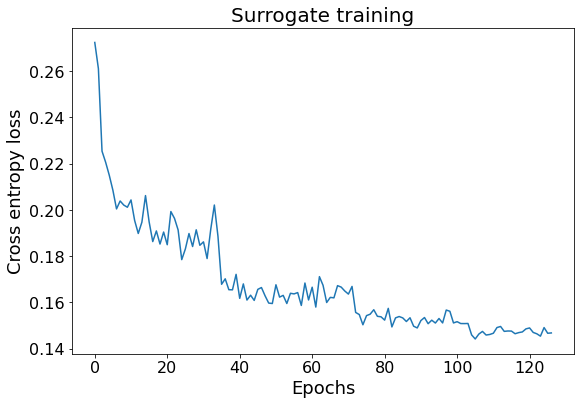

In [6]:
# Plot loss during training
plt.figure(figsize=(9, 6))
plt.plot(loss_list)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Cross entropy loss', fontsize=18)
plt.tick_params(labelsize=16)
plt.title('Surrogate training', fontsize=20)
plt.show()

# Prediction loss explanations

In [7]:
from rexplain import removal, behavior, summary
from rexplain.utils import crossentropyloss

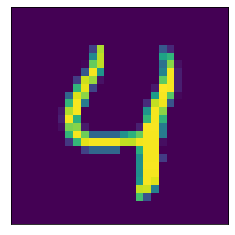

In [8]:
# Find a good digit
ind = 4
plt.imshow(X_test[ind].cpu().data.numpy().reshape((28, 28)))
plt.xticks([])
plt.yticks([])
plt.show()

In [9]:
# Make model callable with numpy input
model_lam = lambda x, S: torch.softmax(
    model((torch.tensor(x, dtype=torch.float32, device=device).reshape(-1, 1, 28, 28),
           torch.tensor(S, dtype=torch.float32, device=device).reshape(-1, 1, 28, 28))),
    dim=1).cpu().data.numpy()

# Model extension
conditional_extension = removal.ConditionalSupervisedExtension(model_lam)

# Cooperative game
game = behavior.PredictionLossGame(conditional_extension, X_test[ind].cpu().numpy(),
                                   Y_test[ind].cpu().numpy(), crossentropyloss)

CPU times: user 78.4 ms, sys: 2.96 ms, total: 81.4 ms
Wall time: 10.4 ms


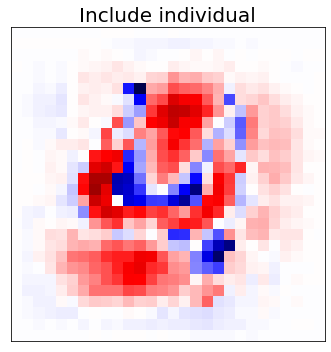

In [10]:
# Summary technique
%time attr = summary.IncludeIndividual(game)

plt.figure(figsize=(5, 5))
m = np.max(np.abs(attr))
plt.imshow(attr.reshape(28, 28), vmin=-m, vmax=m, cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title('Include individual', fontsize=20)
plt.tight_layout()
plt.show()

CPU times: user 1min 50s, sys: 1.77 s, total: 1min 52s
Wall time: 11.3 s


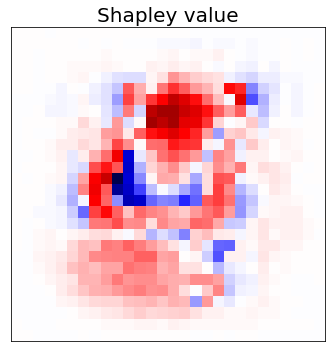

In [11]:
# Summary technique
%time attr = summary.ShapleyValue(game)

plt.figure(figsize=(5, 5))
m = np.max(np.abs(attr))
plt.imshow(attr.reshape(28, 28), vmin=-m, vmax=m, cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title('Shapley value', fontsize=20)
plt.tight_layout()
plt.show()

# Prediction explanations

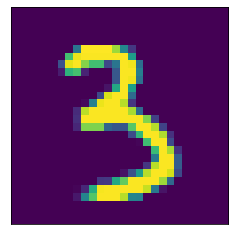

In [12]:
# Find a good digit
ind = 32
actual_digit = 3
contrast_digit = 8
plt.imshow(X_test[ind].cpu().data.numpy().reshape((28, 28)))
plt.xticks([])
plt.yticks([])
plt.show()

In [13]:
# Cooperative game
game = behavior.PredictionGame(conditional_extension, X_test[ind].cpu().numpy())

CPU times: user 75.9 ms, sys: 0 ns, total: 75.9 ms
Wall time: 9.26 ms


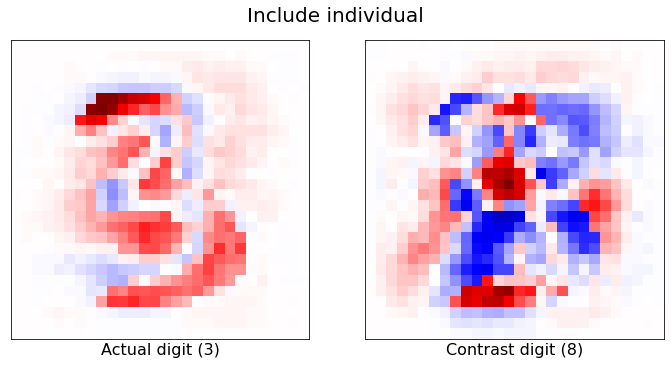

In [14]:
# Summary technique
%time attr = summary.IncludeIndividual(game)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

m = np.max(np.abs(attr[:, actual_digit]))
ax0.imshow(attr[:, actual_digit].reshape(28, 28),
           vmin=-m, vmax=m, cmap='seismic')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_xlabel('Actual digit ({})'.format(actual_digit), fontsize=16)

m = np.max(np.abs(attr[:, contrast_digit]))
ax1.imshow(attr[:, contrast_digit].reshape(28, 28),
           vmin=-m, vmax=m, cmap='seismic')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('Contrast digit ({})'.format(contrast_digit), fontsize=16)

plt.suptitle('Include individual', fontsize=20)
plt.tight_layout()
plt.show()

CPU times: user 9min 43s, sys: 8.85 s, total: 9min 52s
Wall time: 60 s


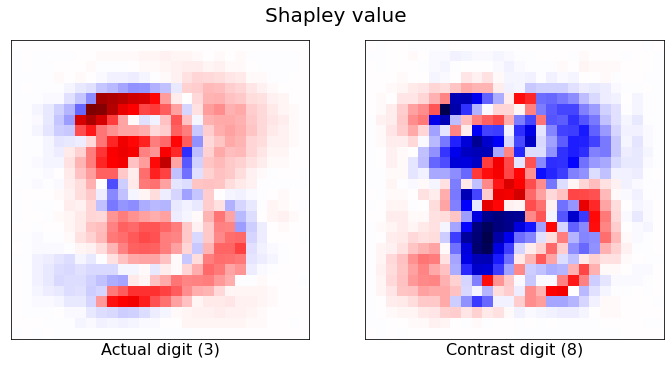

In [15]:
# Summary technique
%time attr = summary.ShapleyValue(game)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

m = np.max(np.abs(attr[:, actual_digit]))
ax0.imshow(attr[:, actual_digit].reshape(28, 28),
           vmin=-m, vmax=m, cmap='seismic')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_xlabel('Actual digit ({})'.format(actual_digit), fontsize=16)

m = np.max(np.abs(attr[:, contrast_digit]))
ax1.imshow(attr[:, contrast_digit].reshape(28, 28),
           vmin=-m, vmax=m, cmap='seismic')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('Contrast digit ({})'.format(contrast_digit), fontsize=16)

plt.suptitle('Shapley value', fontsize=20)
plt.tight_layout()
plt.show()